Notebook purpose:

- Explore from when on we have access to account histories of at least 12 months.

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/mdb_eval")
import src.data.aggregators as agg
import src.data.make_data as md
import src.data.selectors as sl
import src.helpers.data as hd
import src.helpers.io as io

fs = s3fs.S3FileSystem(profile="3di")

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

## load data

In [2]:
dft = dfs = io.read_parquet("s3://3di-data-mdb/clean/mdb_X11.parquet")
hd.inspect(dft)

shape: (6,653,551, 35), users: 2734


,date,user_id,amount,desc,merchant,tag_group,tag_spend,user_registration_date,account_created,account_id,account_last_refreshed,account_provider,account_type,birth_year,data_warehouse_date_created,data_warehouse_date_last_updated,id,is_debit,is_female,is_sa_flow,is_salary_pmt,is_urban,latest_balance,lsoa,merchant_business_line,msoa,postcode,region_name,salary_range,tag,tag_auto,tag_manual,tag_up,updated_flag,ym
0,2012-01-03,11,69.750000,david lloyd <mdbremoved>,david lloyd,spend,sports,2010-06-30,1900-01-01,303733,2014-07-24 11:05:00,lloyds,current,1954.0,2014-07-18,2017-08-15,80656,True,0.0,False,False,1.0,150.029999,e01015428,david lloyd,e02003207,bh15 4,south west,10k to 20k,hobbies,gym membership,no tag,gym membership,u,2012-01
1,2012-01-03,11,96.400002,sky digital xxxxxxxxxx9317,sky,spend,"entertainment, tv, media",2010-06-30,1900-01-01,303733,2014-07-24 11:05:00,lloyds,current,1954.0,2014-07-18,2017-08-15,80654,True,0.0,False,False,1.0,150.029999,e01015428,sky,e02003207,bh15 4,south west,10k to 20k,services,"entertainment, tv, media",no tag,media bundle,u,2012-01


## Create data

In [3]:
def make_data(df):
    aggs = {
        "account_type": "first",
        "account_created": "first",
        "account_provider": "first",
    }

    return (
        df.groupby(["account_id", "ym"], as_index=False)
        .agg(aggs)
        .assign(
            account_created=lambda df: df.account_created.dt.to_period("m"),
            mts_to_creation=lambda df: df.account_created.view(int) - df.ym.view(int),
        )
    )


df = make_data(dft)
df.head(3)

,account_id,ym,account_type,account_created,account_provider,mts_to_creation
0,1014,2014-05,current,2014-06,barclays,1
1,1014,2014-06,current,2014-06,barclays,0
2,1014,2014-07,current,2014-06,barclays,-1


## Availability of account history by account provider and year of account creation

- Below suggests that all major banks start providing historical data of at least 12 months for at least some of their savings and current accounts from April 2017 onwards.
- There is no reason to assume that banks provide different amounts of historical data for different accounts.
- Hence, we can be reasonably sure that we can observe at least 12 months of historical data for all savings and current accounts added after March 2017.

### Maximum available history by bank and year account was added to app

In [6]:
largest_banks = df.account_provider.value_counts().loc[lambda x: x.ge(1000)].index
mask = (
    df.account_provider.isin(largest_banks)
    & df.account_type.isin(["savings", "current"])
    & df.account_created.dt.year.ge(2012)
)

max_history_by_provider_and_year = (
    df[mask]
    .groupby(["account_provider", df.account_created.dt.year, "account_type"])
    .mts_to_creation.describe()
    .loc[:, "max"]
    .unstack()
    .loc[:, ["savings", "current"]]
)
max_history_by_provider_and_year.head(3)

account_type                            savings  current
account_provider       account_created                  
bank of scotland (bos) 2012                 3.0      3.0
                       2013                 2.0      2.0
                       2014                 3.0      3.0

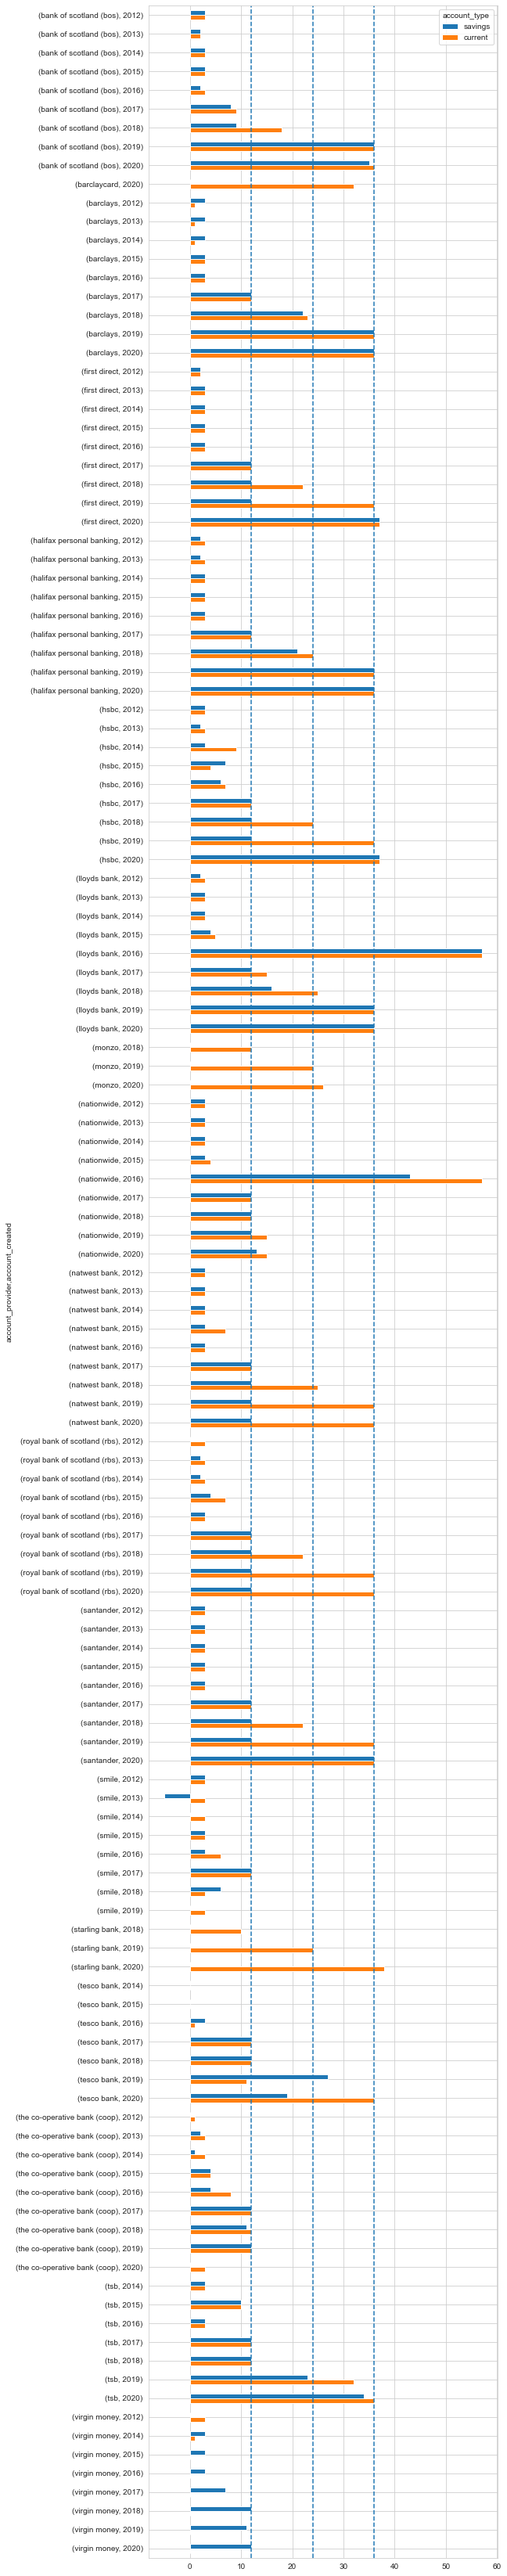

In [7]:
def plot_history(data, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    data.plot(kind="barh", ax=ax)
    ax.invert_yaxis()
    ax.axvline(12, linestyle="--")
    ax.axvline(24, linestyle="--")
    ax.axvline(36, linestyle="--")


plot_history(max_history_by_provider_and_year, figsize=(8, 60))

### Maximum available history by month when account added to app

- Above suggests that 12 months of historical data is becoming available in 2017.
- The purpose of the below is to see in what month.

In [8]:
max_history_by_account_created = (
    df[mask]
    .groupby(["account_created", "account_type"])
    .mts_to_creation.describe()
    .loc[:, "max"]
    .unstack()
    .loc[:, ["savings", "current"]]
)
max_history_by_account_created.head(3)

account_type,savings,current
account_created,,
2012-02,0.0,NaN
2012-03,2.0,2.0
2012-05,NaN,1.0


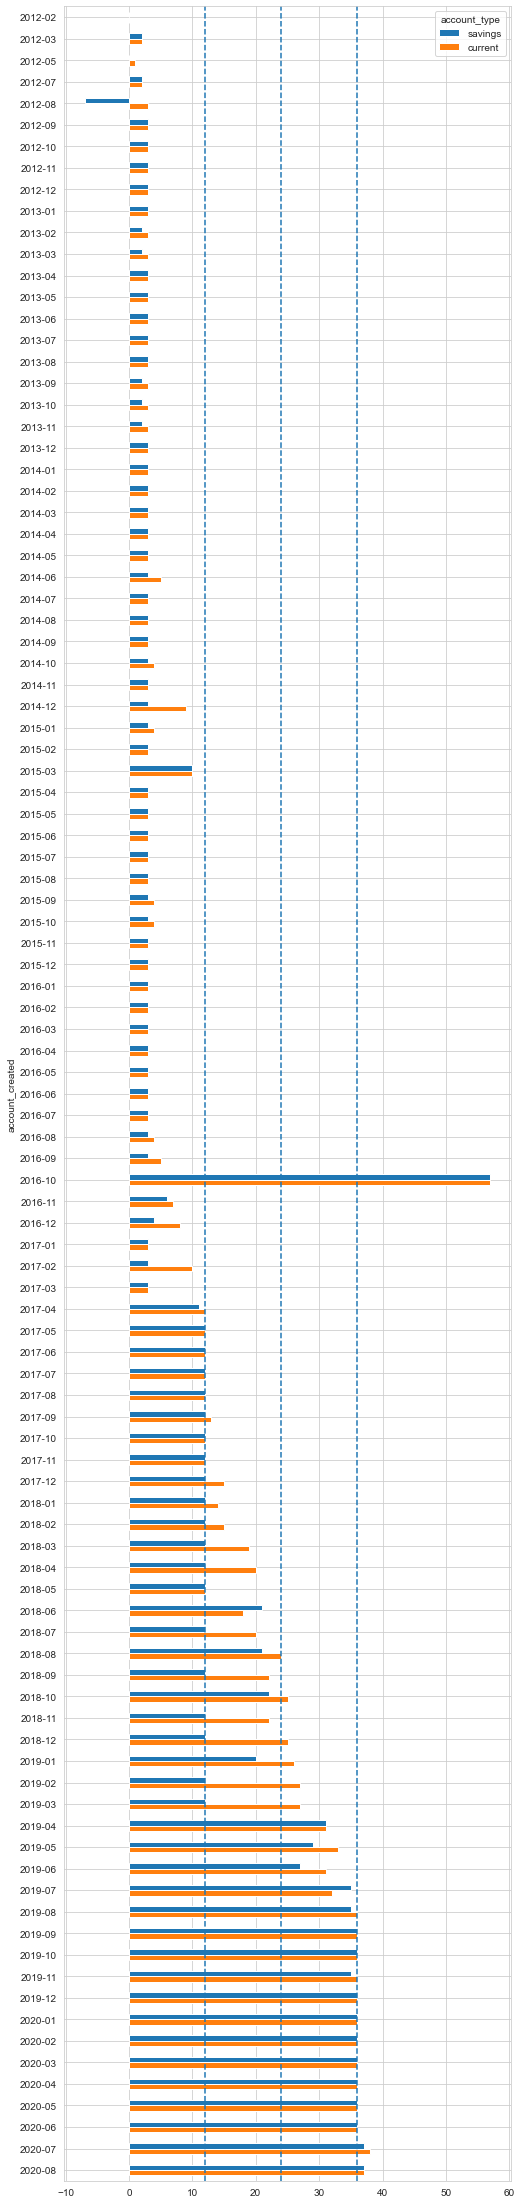

In [9]:
plot_history(max_history_by_account_created, figsize=(8, 40))